<img src='https://datahack-prod.s3.ap-south-1.amazonaws.com/__sized__/contest_cover/cover_copy-thumbnail-1200x1200-90.jpg'>

# Problem Statement

Topic Modeling for Research Articles 2.0
Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more and more difficult. Tagging or topic modelling provides a way to give clear token of identification to research articles which facilitates recommendation and search process. 

Earlier on the Independence Day we conducted a Hackathon to predict the topics for each article included in the test set. Continuing with the same problem, In this Live Hackathon we will take one more step ahead and predict the tags associated with the articles.

Given the abstracts for a set of research articles, predict the tags for each article included in the test set. 
Note that a research article can possibly have multiple tags. The research article abstracts are sourced from the following 4 topics: 

1. Computer Science

2. Mathematics

3. Physics

4. Statistics

List of possible tags are as follows:

[Tags, Analysis of PDEs, Applications, Artificial Intelligence,Astrophysics of Galaxies, Computation and Language, Computer Vision and Pattern Recognition, Cosmology and Nongalactic Astrophysics, Data Structures and Algorithms, Differential Geometry, Earth and Planetary Astrophysics, Fluid Dynamics,Information Theory, Instrumentation and Methods for Astrophysics, Machine Learning, Materials Science, Methodology, Number Theory, Optimization and Control, Representation Theory, Robotics, Social and Information Networks, Statistics Theory, Strongly Correlated Electrons, Superconductivity, Systems and Control]

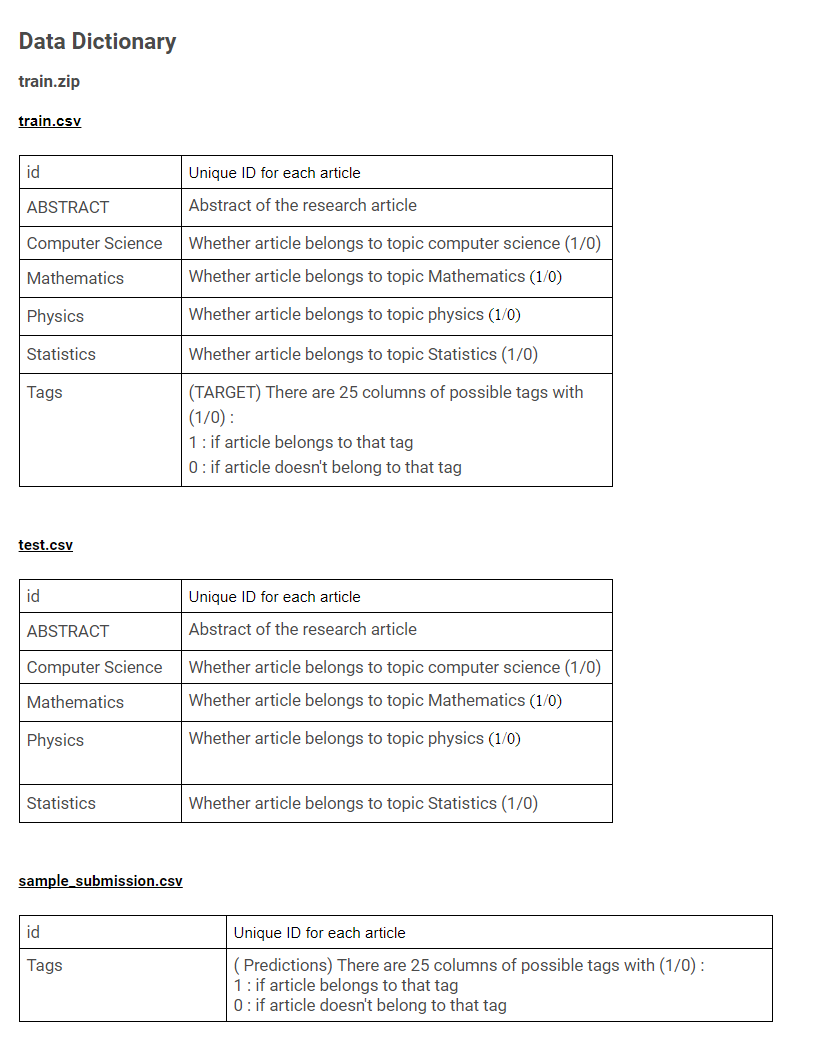

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import xgboost as xgb
import gc
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score,classification_report
from sklearn.model_selection import KFold, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB

from lightgbm import LGBMRegressor
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stop_words = stopwords.words('english')
import seaborn as sns
import string
import unidecode
import re
from skmultilearn.problem_transform import LabelPowerset# initialize label powerset multi-label classifier
%matplotlib inline

In [ ]:
train = pd.read_csv('../input/topic-modeling-for-research-articles/Train.csv')
test = pd.read_csv('../input/topic-modeling-for-research-articles/Test.csv')
ss = pd.read_csv('../input/topic-modeling-for-research-articles/sample_sub.csv')
tags = pd.read_csv('../input/topic-modeling-for-research-articles/Tags.csv')

# Sample Submission File

In [ ]:
ss

# Exploratory Data Analysis

### **1. Brief look at the dataset**.

In [ ]:
train.head(3)
test.head(3)
tags.head(3)

In [ ]:
ID_COL = 'id'

TARGET_COLS = ['Analysis of PDEs', 'Applications',
               'Artificial Intelligence', 'Astrophysics of Galaxies',
               'Computation and Language', 'Computer Vision and Pattern Recognition',
               'Cosmology and Nongalactic Astrophysics',
               'Data Structures and Algorithms', 'Differential Geometry',
               'Earth and Planetary Astrophysics', 'Fluid Dynamics',
               'Information Theory', 'Instrumentation and Methods for Astrophysics',
               'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
               'Optimization and Control', 'Representation Theory', 'Robotics',
               'Social and Information Networks', 'Statistics Theory',
               'Strongly Correlated Electrons', 'Superconductivity',
               'Systems and Control']

TOPIC_COLS = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

In [ ]:
len(TARGET_COLS)

### **2. Dataset Shape (Number of Samples and Variables in the dataset)**

In [ ]:
print(f'\n->->->| Train contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\n->->->| Test contains {test.shape[0]} samples and {test.shape[1]} variables')
print(f'\n->->->| Number of distinct SUB TOPICS is {len(TARGET_COLS)}')

features = [c for c in train.columns if c not in [ID_COL] + TARGET_COLS]
print(f'\n->->->| The dataset contains {len(features)} features')

### **3.Target Distribution**

In [ ]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

### **4. Variable Datatypes**

Lets have a look at the kind of data types that is being used to store the variables in pandas.

pandas info() method on dataframe allows to do that. For each variable we can see the number of non-null values along with their datatypes.



In [ ]:
train.info()

### **5. Null Values**

Although the info() function did tell us about non-null values ideally we want to have a look at the percentage of null values in each variable.

In [ ]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

### **6. Unique values in each variable**

In [ ]:
train.nunique()

**ADDITIONAL DESCRIPTIVE EDA**

In [ ]:
train[TOPIC_COLS].sum().sort_values(ascending=False)

In [ ]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

# Visual Exploratory Data Analysis Through WordClouds

In [ ]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(stopwords = set(list(STOPWORDS) + ['inside']), random_state = 42)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(['Machine Learning', 'Artificial Intelligence', 'Computer Vision and Pattern Recognition', 'Robotics']):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN SUBTOPIC', fontsize=30)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(TOPIC_COLS):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN TOPIC', fontsize=30)

# Model Building

## Bag of Words Approach

* **Text**: Collection of Words
* **Word**: Adds some kind of meaning to the sentence.
* We make a bag containing all the words in our dataset.
* **Features** : How many times is a particular word from the bag is present in our sentence ?

#### Simple Example

In [ ]:
sent1 = 'Artificial Intelligence is the future'
sent2 = 'Analytics Vidhya is the best platform to learn Artificial Intelligence'
sent3 = 'To build a better future the way forward is to learn and improve constantly'

In [ ]:
all_sentences = [sent1, sent2, sent3]
all_words = [w for sent in all_sentences for w in sent.split()]
all_words = list(set(all_words))
all_words

In [ ]:
columns = {word: [] for word in all_words}
for word in all_words:
  for sent in all_sentences:
    sent_words = sent.split()
    count = sum([(word==w) for w in sent_words])
    columns[word].append(count)

In [ ]:
sent1 = 'Artificial Intelligence is the future '
sent2 = 'Analytics Vidhya is the best platform to learn Artificial Intelligence'
sent3 = 'To build a better future the way forward is to learn and improve constantly'

In [ ]:
counts = pd.DataFrame(columns)

In [ ]:
counts

## Count Vectorizer

In [ ]:
vec = CountVectorizer(max_features=10000)
combined = list(train['ABSTRACT']) + list(test['ABSTRACT'])
vec.fit(combined)

In [ ]:
trn, val = train_test_split(train, test_size=0.2, random_state=2)

In [ ]:
trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])

In [ ]:
trn[TARGET_COLS]

In [ ]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
clf.fit(trn_abs, trn[TARGET_COLS])

In [ ]:
val_preds = clf.predict(val_abs)
f1_score(val[TARGET_COLS], val_preds, average='micro')

In [ ]:
preds_test = clf.predict(tst_abs)

In [ ]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COLS] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

In [ ]:
download_preds(preds_test, 'hacklive_NLP_count.csv')

## **Tfidf Vectorizer**

In [ ]:
counts

**TF-IDF** = Term-Frequency * Inverse Document Frequency

**Term-Frequency** = (Frequency of the word in the sentence) / (Total number of words in the sentence)

**Inverse Document Frequency** = (Total number of sentences)/(Number of sentences containing the word)

#### Simple Example

In [ ]:
sent1 = 'Artificial Intelligence is the future'
sent2 = 'Analytics Vidhya is the best platform to learn Artificial Intelligence'
sent3 = 'To build a better future the way forward is to learn and improve constantly'

In [ ]:
term_frequency = counts.copy()
term_frequency = term_frequency.apply(lambda x: x/term_frequency.sum(axis = 1))
term_frequency

In [ ]:
inverse_document_frequency = counts.copy()
inverse_document_frequency = inverse_document_frequency.apply(lambda x: 3/(x > 0).sum())
inverse_document_frequency

In [ ]:
tfidf = term_frequency * inverse_document_frequency
tfidf

In [ ]:
vec = TfidfVectorizer(max_features=10000)
_ = vec.fit(list(train['ABSTRACT']) + list(test['ABSTRACT']))

trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])

clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_ = clf.fit(trn_abs, trn[TARGET_COLS])

val_preds = clf.predict(val_abs)
f1_score(val[TARGET_COLS], val_preds, average='micro')

In [ ]:
preds_test = clf.predict(tst_abs)
download_preds(preds_test, 'hacklive_NLP_tfidf.csv')

### **Optimal Threshold for F1-score**

In [ ]:
def get_best_thresholds(true, preds):
  thresholds = [i/100 for i in range(100)]
  best_thresholds = []
  for idx in range(25):
    f1_scores = [f1_score(true[:, idx], (preds[:, idx] > thresh) * 1) for thresh in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_thresh)
  return best_thresholds

In [ ]:
val_preds = clf.predict_proba(val_abs)

best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)

for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1
  
f1_score(val[TARGET_COLS], val_preds, average='micro')

In [ ]:
preds_test = clf.predict_proba(tst_abs)

for i, thresh in enumerate(best_thresholds):
  preds_test[:, i] = (preds_test[:, i] > thresh) * 1

download_preds(preds_test, 'hacklive_NLP_tfidf_threshold_optimized.csv')

In [ ]:
TOPIC_COLS

**Combining Topics**

In [ ]:
trn_abs.shape

In [ ]:
vec = CountVectorizer(max_features=10000)
_ = vec.fit(list(train['ABSTRACT']) + list(test['ABSTRACT']))

trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])
print(trn_abs.shape, val_abs.shape, tst_abs.shape)

trn2 = np.hstack((trn_abs.toarray(), trn[TOPIC_COLS]))
val2 = np.hstack((val_abs.toarray(), val[TOPIC_COLS]))
tst2 = np.hstack((tst_abs.toarray(), test[TOPIC_COLS]))

print(trn2.shape, val2.shape, tst2.shape)

In [ ]:
from scipy.sparse import csr_matrix

trn2 = csr_matrix(trn2.astype('int16'))
val2 = csr_matrix(val2.astype('int16'))
tst2 = csr_matrix(tst2.astype('int16'))

In [ ]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_  = clf.fit(trn2, trn[TARGET_COLS])

val_preds = clf.predict_proba(val2)
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)

for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1

f1_score(val[TARGET_COLS], val_preds, average='micro')

In [ ]:
preds_test = clf.predict_proba(tst2)

for i, thresh in enumerate(best_thresholds):
  preds_test[:, i] = (preds_test[:, i] > thresh) * 1

download_preds(preds_test, 'hacklive_NLP_count_added_topics.csv')

**What more can you do ?**

* Hyperparameter tuning (Refer earlier Hacklive Sessions).
* n-gram models instead of 1 gram models. Try 2-gram models, 3-gram models.
* Text Cleaning.


## **Word Embeddings**

* Problems with BOW approach.


In [ ]:
train['text'] = ' '
test['text'] = ' '


train['text'] += train['ABSTRACT']
test['text'] += test['ABSTRACT']

trn, val = train_test_split(train, test_size=0.2, random_state=2)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tok = Tokenizer(num_words = 1000000)
tok.fit_on_texts(train['text'].str.lower().tolist() + test['text'].str.lower().tolist())

vocab_size = len(tok.word_index) + 1

In [ ]:
X_trn = tok.texts_to_sequences(trn['text'])
X_val = tok.texts_to_sequences(val['text'])
X_test = tok.texts_to_sequences(test['text'])

In [ ]:
maxlen = 200
X_trn = pad_sequences(X_trn, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, SpatialDropout1D, LSTM


embedding_dim = 50
vocab_size = len(tok.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))

model.add(Flatten())
model.add(Dense(200, activation='relu', name = 'Fully_Connected'))
model.add(Dense(25, activation='sigmoid', name = 'Output'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )

model.summary()

#### **Model Architecture**

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.fit(X_trn, trn[TARGET_COLS], validation_data=(X_val, val[TARGET_COLS]), verbose=True, epochs=20, batch_size=256,
          callbacks = [tf.keras.callbacks.ReduceLROnPlateau()])

In [ ]:
def get_best_thresholds(true, preds):
  thresholds = [i/100 for i in range(100)]
  best_thresholds = []
  for idx in range(25):
    f1_scores = [f1_score(true[:, idx], (preds[:, idx] > thresh) * 1) for thresh in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_thresh)
  return best_thresholds

val_preds = model.predict(X_val)
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)
for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1
f1_score(val[TARGET_COLS], val_preds, average='micro')

In [ ]:
preds_test = model.predict(X_test)

for i, thresh in enumerate(best_thresholds):
  preds_test[:, i] = (preds_test[:, i] > thresh) * 1
  
download_preds(preds_test, 'hacklive_NLP_word_embeddings.csv')

## **Ideas to progress further !!!**

* Try pretrained word embeddings.
* Try using LSTMs instead of simple fully connected layers.
* Try using SOTA Models.
* Ensembling ? Can we combine all these models ?


# **Useful Links**

https://huggingface.co/transformers

https://github.com/ThilinaRajapakse/simpletransformers